# <font style = "color:rgb(50,120,229)">ORB (Oriented FAST and Rotated BRIEF)</font>

In this notebook, we will see how to detect ORB features and in the next sections, we will discuss how to use them for different applications.

## <font style="color:rgb(50,120,229)">Recap </font>
ORB is basically a fusion of FAST keypoint detector and BRIEF descriptor with many modifications to enhance the performance. First it use FAST to find keypoints, then apply Harris corner measure to find top N points among them. It also use pyramid to produce multiscale-features. But one problem is that, FAST doesn't compute the orientation. So what about rotation invariance? Authors came up with following modification.

It computes the intensity weighted centroid of the patch with located corner at center. The direction of the vector from this corner point to centroid gives the orientation. To improve the rotation invariance, moments are computed with x and y which should be in a circular region of radius r, where r is the size of the patch.

Now for descriptors, ORB use BRIEF descriptors. But we have already seen that BRIEF performs poorly with rotation. So what ORB does is to "steer" BRIEF according to the orientation of keypoints. For any feature set of $n$ binary tests at location $(x_i,y_i)$, define a $2 \times n$ matrix, $S$ which contains the coordinates of these pixels. Then using the orientation of patch, $\theta$, its rotation matrix is found and rotates the $S$ to get steered(rotated) version $S_{\theta}$.

ORB discretize the angle to increments of $\frac{2\pi}{30}$ (12 degrees), and construct a lookup table of precomputed BRIEF patterns. As long as the keypoint orientation $\theta$ is consistent across views, the correct set of points $S_{\theta}$ will be used to compute its descriptor.

BRIEF has an important property that each bit feature has a large variance and a mean near 0.5. But once it is oriented along keypoint direction, it loses this property and become more distributed. High variance makes a feature more discriminative, since it responds differentially to inputs. Another desirable property is to have the tests uncorrelated, since then each test will contribute to the result. To resolve all these, ORB runs a greedy search among all possible binary tests to find the ones that have both high variance and means close to 0.5, as well as being uncorrelated. The result is called **rBRIEF**.

For descriptor matching, multi-probe LSH which improves on the traditional LSH, is used. The paper says ORB is much faster than SURF and SIFT and ORB descriptor works better than SURF. ORB is a good choice in low-power devices for panorama stitching etc.


## <font style = "color:rgb(50,120,229)">ORB in OpenCV</font>

### <font style = "color:rgb(8,133,37)">Function Syntax</font>

Let's have a look at the function syntax for [**`cv2.ORB_create()`**](https://docs.opencv.org/4.1.0/db/d95/classcv_1_1ORB.html#aeff0cbe668659b7ca14bb85ff1c4073b) function which is used to create an ORB detector.

```python
retval	=	cv2.ORB_create()
```
The above function has many arguments, but the default ones work pretty well. It creates an object with 500 features points.

The ORB belongs to the [**feature2D class**](https://docs.opencv.org/3.4/d0/d13/classcv_1_1Feature2D.html). It has a few important functions : [**`cv2.Feature2D.detect()`**](https://docs.opencv.org/4.1.0/d0/d13/classcv_1_1Feature2D.html#aa4e9a7082ec61ebc108806704fbd7887), [**`cv2.Feature2D.compute()`**](https://docs.opencv.org/4.1.0/d0/d13/classcv_1_1Feature2D.html#ab3cce8d56f4fc5e1d530b5931e1e8dc0) and [**`cv2.Feature2D.detectAndCompute()`**](https://docs.opencv.org/4.1.0/d0/d13/classcv_1_1Feature2D.html#a8be0d1c20b08eb867184b8d74c15a677) which can be used as `orb.detect()`, `orb.compute()` and `orb.detectAndCompute()` where, `orb = cv2.ORB_create()`.

Let's see the function syntax:

#### <font style = "color:rgb(8,133,37)">1. **cv2.Feature2D.detect()**</font>
```python
keypoints	=	cv2.Feature2D.detect(	image[, mask]	)
```

Where,

- **`image`** - Image.
- **`keypoints`** - The detected keypoints. In the second variant of the method keypoints[i] is a set of keypoints detected in images[i] .
- **`mask`** - Mask specifying where to look for keypoints (optional). It must be a 8-bit integer matrix with non-zero values in the region of interest.


#### <font style = "color:rgb(8,133,37)">2. **cv2.Feature2D.compute()**</font>


```python
keypoints, descriptors	=	cv2.Feature2D.compute(	image, keypoints[, descriptors]	)
```

Where,

- **`image`**- Image.
- **`keypoints`** - Input collection of keypoints. Keypoints for which a descriptor cannot be computed are removed. Sometimes new keypoints can be added, for example: SIFT duplicates keypoint with several dominant orientations (for each orientation).
- **`descriptors`** - Computed descriptors. In the second variant of the method descriptors[i] are descriptors computed for a keypoints[i]. Row j is the keypoints (or keypoints[i]) is the descriptor for keypoint j-th keypoint.



And finally:
#### <font style = "color:rgb(8,133,37)">3. **cv2.Feature2D.detectAndCompute()**</font>

```python
keypoints, descriptors	=	cv2.Feature2D.detectAndCompute(	image, mask[, descriptors[, useProvidedKeypoints]]	)
```

We can also draw the detected keypoints using [**`cv2.drawKeypoints()`**](https://docs.opencv.org/4.1.0/d4/d5d/group__features2d__draw.html#ga5d2bafe8c1c45289bc3403a40fb88920)

#### <font style = "color:rgb(8,133,37)">4. **cv2.drawKeypoints()**</font>
```python
outImage	=	cv2.drawKeypoints(	image, keypoints, outImage[, color[, flags]]	)
```

Where,

- **`image`** - Source image.
- **`keypoints`** - Keypoints from the source image.
- **`outImage`** - Output image. Its content depends on the flags value defining what is drawn in the output image. See possible flags bit values below.
- **`color`** - Color of keypoints.
- **`flags`** - Flags setting drawing features. Possible flags bit values are defined by DrawMatchesFlags. See details above in drawMatches

Below is a simple code which shows the use of ORB.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from dataPath import DATA_PATH
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
matplotlib.rcParams['image.cmap'] = 'gray'

In [3]:
# Read input image
img = cv2.imread(DATA_PATH + "images/book.jpeg")
# Convert to grayscale
imgGray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

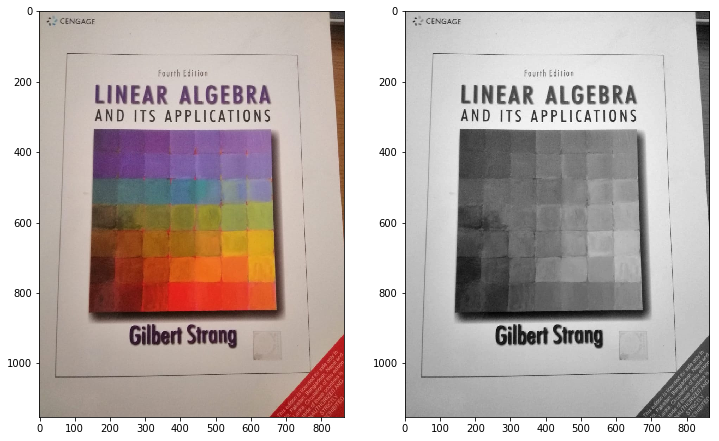

In [4]:
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(img[:,:,::-1])
plt.subplot(1,2,2)
plt.imshow(imgGray)
plt.show()

In [21]:
# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints with ORB
kp = orb.detect(imgGray,None)

In [22]:
# compute the descriptors with ORB
kp, des = orb.compute(imgGray, kp)

In [23]:
# draw keypoints location, size and orientation
img2 = cv2.drawKeypoints(img, kp, None, color=(0,255,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

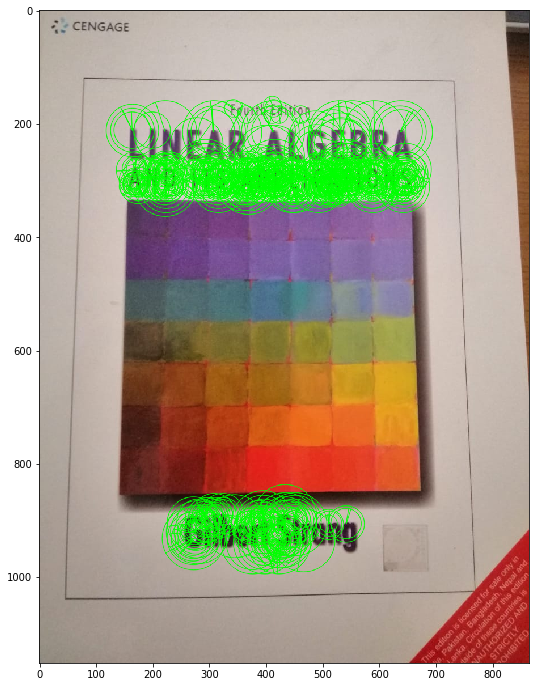

In [25]:
plt.figure(figsize=(12,12))
plt.imshow(img2[:,:,::-1])

The above image shows the features along with their location, size and orientation. 

### <font style = "color:rgb(8,133,37)">**One thing to note is that there are no features in the white or plain region as expected.**</font>

Let us have a closer look and display only 10 features.

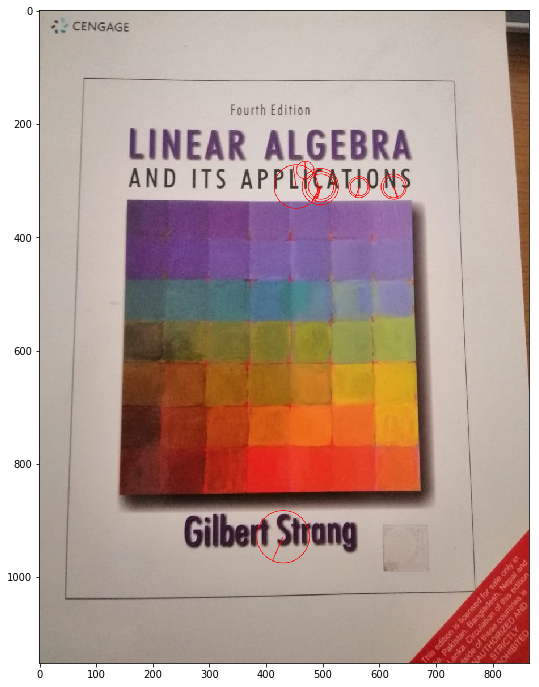

In [26]:
orb = cv2.ORB_create(10)
kp, des = orb.detectAndCompute(imgGray, None)
img2 = cv2.drawKeypoints(img, kp, None, color=(0,0,255), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(12,12))
plt.imshow(img2[:,:,::-1])